In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
from scipy import ndimage
import ghalton
import dicom
from scipy.interpolate import interp1d

In [2]:
'''
Helper function that cleans up list_directory
removes hidden files
'''
def clean(lis):
    try:
         
        lis.remove('.DS_Store')
    except:
        lis = lis
    return lis

'''
Helper function that retrieves all data files
cleans up the directory to leave only .dat files
'''
def get_files(lis):
    try:
        for i in list(lis):
            if('.dat' not in i):
                lis.remove(i)
    except:
        lis = lis
    return lis

#Bicubic Interpolation#

<img src = "./cubic.png" height="400" width="400">

We have some points, a, b, c, d, and we need to estimate the value at x. Bicubic interplolation, unlike linear interpolation constructs a cubic piecewise function between a and b, and use that cubic function to estimate the unknown point x. Now that we have a cubic function, there will be four coefficients, so we neet four known points to solve the system.

$$f(x) = \sum\limits_{i=0}^{i=3}a_i x^i = a_0 + a_1x+ a_2x^2 + a_3x^3$$

Then, we compute this function at the four known points

$$
\left\{
\begin{array}{ll}
      f(c) = a_0 + a_1c+ a_2c^2 + a_3c^3 \\
      f(a) = a_0 + a_1a+ a_2a^2 + a_3a^3 \\
      f(b) = a_0 + a_1b+ a_2b^2 + a_3b^3 \\
      f(d) = a_0 + a_1d+ a_2d^2 + a_3d^3 \\
\end{array} 
\right.
$$

We can rewrite the equations into matrix form. 
$$
\begin{bmatrix}
f(c) \\
f(a) \\
f(b) \\
f(d) \\
\end{bmatrix} =
\begin{bmatrix}
1 & 1 & 1 & 1 \\
c & a & b & d \\
c^2 & a^2 & b^2 & d^2 \\
c^3 & a^3 & b^3 & d^3 \\
\end{bmatrix}
\begin{bmatrix}
a_0\\
a_1\\
a_2\\
a_3 \\
\end{bmatrix}
$$

Denote the above equation as $\boldsymbol{Y} = \boldsymbol{X}\boldsymbol{A}$, we can solve for the coefficients $\boldsymbol{A} = \boldsymbol{X}^{-1}\boldsymbol{Y}$

<img src = "./bicubic.png" height="400" width="400">

Now for 2 dimention, say that we need to estimate the value at point $(x,y) = (\frac{1}{2},\frac{1}{2})$, we need to interpolate using the values at the grid around, and the derivatives of the cubic function ${f(\cdot)}$ at these grid points. 

$$f(x,y) = \sum_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j$$

With $a_{ij}$ defined as follows,
$$
\begin{align*}
f(0,0) &= a_{00}\\
f(1,0) &= a_{00} + a_{10} + a_{20} + a_{30}\\
f(0,1) &= a_{00} + a_{01} + a_{02} + a_{03}\\
f(1,1) &=\sum_{i=0}^3 \sum_{j=0}^3 a_{ij}\\
\partial_xf(0,0) &= a_{10}\\
\partial_xf(1,0) &= a_{10} + 2a_{20} + 3a_{30}\\
\partial_xf(0,1) &= a_{10} + a_{11} + a_{12} + a_{13}\\
\partial_xf(1,1) &= \sum_{i=1}^3 \sum_{j=0}^3 a_{ij} i  \\
\partial_yf(0,0) &= a_{01}\\
\partial_yf(1,0) &= a_{01} + a_{11} + a_{21} + a_{31}\\
\partial_yf(0,1) &= a_{01} + 2a_{02} + 3a_{03}\\
\partial_yf(1,1) &= \sum_{i=0}^3 \sum_{j=1}^3 a_{ij} j \\
\partial_{xy}f(0,0) &= a_{11}\\
\partial_{xy}f(1,0) &= a_{11} + 2a_{21} + 3a_{31}\\
\partial_{xy}f(0,1) &= a_{11} + 2a_{12} + 3a_{13}\\
\partial_{xy}f(1,1) &= \sum_{i=1}^3 \sum_{j=1}^3 a_{ij} i j \\
\end{align*}
$$

Now we can compute the value for point (x,y),
$$
\begin{align}
f(x,y) &= \sum_{i=0}^3 \sum_{j=0}^3 a_{ij} x^{i} y^j\\
\partial_xf(x,y) &= \sum_{i=1}^3 \sum_{j=0}^3 a_{ij} i x^{i-1} y^j\\
\partial_yf(x,y) &= \sum_{i=0}^3 \sum_{j=1}^3 a_{ij} x^i j y^{j-1}\\
\partial_{xy}f(x,y) &= \sum_{i=1}^3 \sum_{j=1}^3 a_{ij} i x^{i-1} j y^{j-1}\\
\end{align}
$$

In matrix form we have,

$$
\boldsymbol{A}=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T\\
\boldsymbol{Y}=\left[\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&\partial_xf(0,0)&\partial_xf(1,0)&\partial_xf(0,1)&\partial_xf(1,1)&\partial_yf(0,0)&\partial_yf(1,0)&\partial_yf(0,1)&\partial_yf(1,1)&\partial_{xy}f(0,0)&\partial_{xy}f(1,0)&\partial_{xy}f(0,1)&\partial_{xy}f(1,1)\end{smallmatrix}\right]^T
$$

We have $\boldsymbol{Y} = \boldsymbol{X}\boldsymbol{A}$, we can solve for the coefficients $\boldsymbol{A} = \boldsymbol{X}^{-1}\boldsymbol{Y}$, where X is as follows,



In [3]:
X_inv = np.zeros([16,16])
X_inv[0][0] = 1
X_inv[1][4] = 1
X_inv[2][0:6] = [-3,3,0,0,-2,-1]
X_inv[3][0:6] = [2,-2,0,0,1,1]
X_inv[4][8] = 1 
X_inv[5][12] = 1
X_inv[6][8:14] = [-3,3,0,0,-2,-1]
X_inv[7][8:14] = [2,-2,0,0,1,1]
X_inv[8][0:3] = [-3,0,3]
X_inv[8][8:11] = [-2,0,-1]
X_inv[9][4:7] = [-3,0,3]
X_inv[9][12:15] = [-2,0,-1]
X_inv[10] = [9,-9,-9,9, 6,3,-6,-3,6,-6,3,-3,4,2,2,1]
X_inv[11] = [-6,6,6,-6,-3,-3,3,3,-4,4,-2,2,-2,-2,-1,-1]
X_inv[12][0:3] = [2,0,-2]
X_inv[12][8:11:2] = 1
X_inv[13][4:7] = [2,0,-2]
X_inv[13][12:15:2] = 1
X_inv[14] = [-6,6,6,-6,-4,-2,4,2,-3,3,-3,3,-2,-1,-2,-1]
X_inv[15] = [4,-4,-4,4,2,2,-2,-2,2,-2,2,-2,1,1,1,1]
print X_inv

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-3.  3.  0.  0. -2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2. -2.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -3.  3.  0.  0. -2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2. -2.  0.  0.  1.  1.  0.  0.]
 [-3.  0.  3.  0.  0.  0.  0.  0. -2.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -3.  0.  3.  0.  0.  0.  0.  0. -2.  0. -1.  0.]
 [ 9. -9. -9.  9.  6.  3. -6. -3.  6. -6.  3. -3.  4.  2.  2.  1.]
 [-6.  6.  6. -6. -3. -3.  3.  3. -4.  4. -2.  2. -2. -2. -1. -1.]
 [ 2.  0. -2.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0. -2.  0.  0.  0.  0.  0.  1.  0.  1.  0.]
 [-6.  6.  6. -6. -4. -2.  4.  2. -3.  3. -3.  3. -2. -1. -2. 

In [4]:
def get_target_Y(x,y):
    Y = np.zeros([len(x),16])
    Y[:,0] = 1.
    Y[:,1] = x
    Y[:,2] = x**2
    Y[:,3] = x**3
    Y[:,4] = y
    Y[:,5] = x*y
    Y[:,6] = x**2*y
    Y[:,7] = x**3*y
    Y[:,8] = y**2
    Y[:,9] = x*y**2
    Y[:,10] = x**2*y**2
    Y[:,11] = x**3*y**2
    Y[:,12] = y**3
    Y[:,13] = x*y**3
    Y[:,14] = x**2*y**3
    Y[:,15] = x**3*y**3
    return Y

In [5]:
def bicubic_interp(image, x, y):
    xr = x.ravel()
    yr = y.ravel()
    
    # find the closes grid of the target points
    x1 = np.floor(x).astype(int)
    
    # Take care of boundary conditions
    # check if the input grid x, y is already on the original grid (i.e. special rotations)
    if (len(x)==len(image)):
        if(np.allclose(x.astype(int),x1)):
            return image[y.astype(int),x.astype(int)]
    x0 = x1 - 1
    x2 = x1 + 1
    x3 = x2 + 1
    y1 = np.floor(y).astype(int)
    y0 = y1 - 1
    y2 = y1 + 1
    y3 = y2 + 1
    
    # we need to clip the range 
    x0 = np.clip(x0, 0, image.shape[1]-1)
    x1 = np.clip(x1, 0, image.shape[1]-1)
    x2 = np.clip(x2, 0, image.shape[1]-1)
    x3 = np.clip(x3, 0, image.shape[1]-1)
    y0 = np.clip(y0, 0, image.shape[0]-1)
    y1 = np.clip(y1, 0, image.shape[0]-1)
    y2 = np.clip(y2, 0, image.shape[0]-1)
    y3 = np.clip(y3, 0, image.shape[0]-1)
    
    # compute the vector of coefficients A
    # first compute vector Y from known points to solve for A
    Y = np.zeros([16,len(xr)])
    Y[0] = image[y1,x1].ravel()
    Y[1] = image[y1,x2].ravel()
    Y[2] = image[y2,x1].ravel()
    Y[3] = image[y2,x2].ravel()
    
    Y[4] = ((image[y1,x2]-image[y1,x0])/2.).ravel()
    Y[5] = ((image[y1,x3]-image[y1,x1])/2.).ravel()
    Y[6] = ((image[y2,x2]-image[y2,x0])/2.).ravel()
    Y[7] = ((image[y2,x3]-image[y2,x1])/2.).ravel()
    
    Y[8] = ((image[y2,x1]-image[y0,x1])/2.).ravel()
    Y[9] = ((image[y2,x2]-image[y0,x2])/2.).ravel()
    Y[10] = ((image[y3,x1]-image[y1,x1])/2.).ravel()
    Y[11] = ((image[y3,x2]-image[y1,x2])/2.).ravel()
    
    Y[12] = ((image[y2,x2]-image[y2,x0]-image[y1,x2]+image[y1,x0])/4.).ravel()
    Y[13] = ((image[y0,x3]-image[y0,x1]-image[y2,x3]+image[y2,x1])/4.).ravel()
    Y[14] = ((image[y3,x2]-image[y3,x0]-image[y1,x2]+image[y1,x0])/4.).ravel()
    Y[15] = ((image[y3,x3]-image[y3,x1]-image[y1,x3]+image[y1,x1])/4.).ravel()
    # Compute A
    A = np.dot(X_inv,Y)
    
    # get vector Y from points that need to be interpolated
    target_Y = get_target_Y(xr-np.floor(xr), yr-np.floor(yr))
    # compute result
    result = np.dot(target_Y,A)
    # only need the diagonal values and reshape them back to original shape
    return np.reshape(result.diagonal(),x.shape)

##Define imrotate##

The rotation matrix in 2D is as follows,

$$R(\theta) = \begin{bmatrix}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta \\
\end{bmatrix}$$

If we need to rotate the point (x,y) by $\theta$ degrees counterclock wise, then the coordinates for the new point is 
$(\cos \theta x + \sin\theta y, \sin\theta x+\cos\theta y)$

In [6]:
def to_radian(theta):
    return theta*np.pi/180.

def rotate_coords(x, y, theta, ox, oy):
    """
    Rotate arrays of coordinates x and y by theta radians about the
    point (ox, oy).

    """
    s, c = np.sin(theta), np.cos(theta)
    # round up the sin and cos to 15 decimals
    s = np.round(s,15)
    c = np.round(c,15)
    x, y = np.asarray(x) - ox, np.asarray(y) - oy
    return x * c - y * s + ox, x * s + y * c + oy

def circle_mask(image):
    tmp = image.copy()
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    tmp[~mask] = 0
    return tmp

def imrotate(image, theta, interpolation = 'bilinear', mask=False, x=None, y=None):
    theta = to_radian(theta)
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    if((x == None) and (y == None)): #i.e. x and y not specified
        x = np.linspace(0, image.shape[1]-1, image.shape[1]).astype(int)
        y = np.linspace(0, image.shape[0]-1, image.shape[0]).astype(int)
    
    xx, yy = np.meshgrid(x,y)
    
    dest_x, dest_y = rotate_coords(xx, yy, theta, ox, oy)
    
    if(interpolation == 'bicubic'):
        dest = bicubic_interp(image, dest_x, dest_y)
    if(interpolation == 'bilinear'):
        dest = bilinear_interp(image, dest_x, dest_y)
    if(interpolation == 'scipy1'):
        dest = ndimage.interpolation.map_coordinates(image, np.array([dest_x,dest_y]) , order=1)
    if(interpolation == 'scipy3'):
        dest = ndimage.interpolation.map_coordinates(image, np.array([dest_x,dest_y]) , order=3)
        
    if(mask):
        dest = circle_mask(dest)
    return dest

#Cost Functions:#

In [7]:
def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

Note that in this function I'm slicing the volume in 2D, rotate each 2D image and put the back together, so the cost function results are of teh 3D volume.

In [8]:
def rot_cost_func(vol1, vol2, thetas, cf, arg, ax, interpolation = 'bilinear',mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(32):
            if(mask):
                vol1[i,:,:] = circle_mask(vol1[i,:,:])
            sub = vol2[i,:,:]
            rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot
        cost_func[idx] = cf(new_vol2,vol1)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=4)

In [9]:
def rot_vol(vol2, theta):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    '''
    new_vol2 = np.empty(vol2.shape)
    for i in xrange(32):
        sub = vol2[i,:,:]
        rot = imrotate(sub, theta)
        new_vol2[i,:,:] = rot
    return new_vol2

## Test with Real Data

In [10]:
path = '/Users/zyzdiana/Dropbox/Spring2015/AC297r/Pineapple_images/'
files = get_files(os.listdir(path))

# Choose two volume and slice them to for testing.
vol1 = np.array(np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32)))
vol2 = np.array(np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32)))

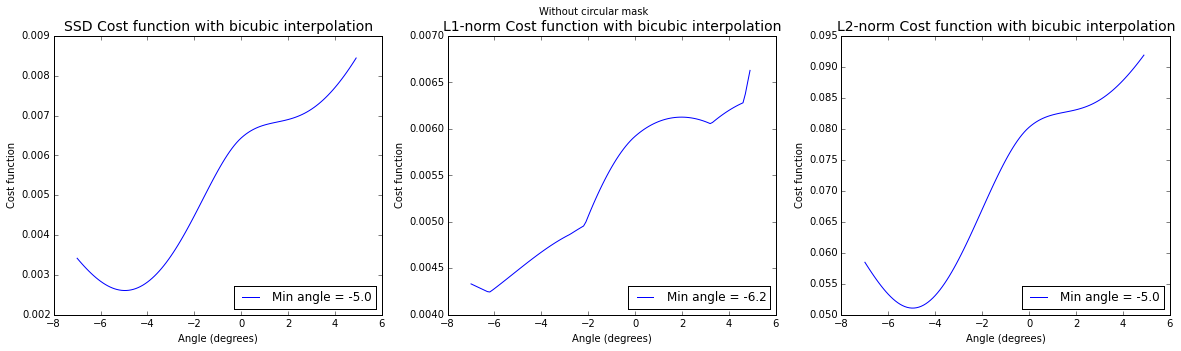

In [11]:
# Cost function from Bicubic Interpolation
thetas=np.arange(-7,5,0.1)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bicubic')
plt.show()
plt.close(fig)

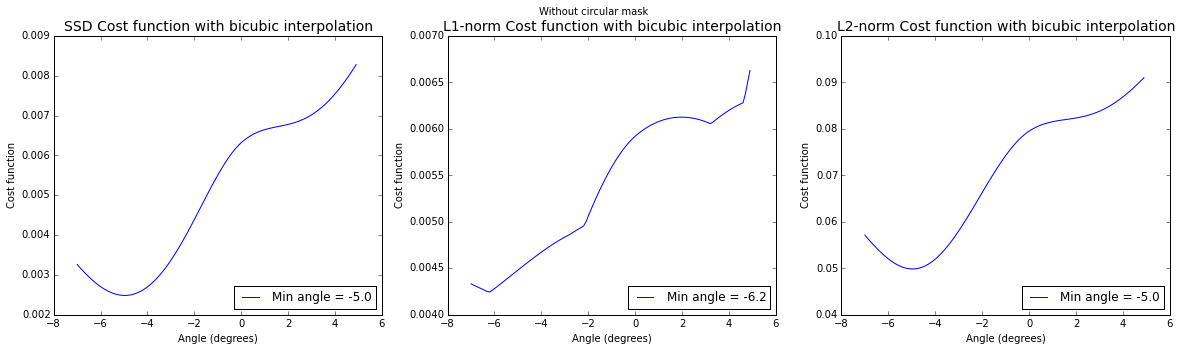

In [32]:
# Cost function from Bicubic Interpolation
thetas=np.arange(-7,5,0.1)
# with circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bicubic', mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bicubic', mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bicubic', mask=True)
plt.show()
plt.close(fig)

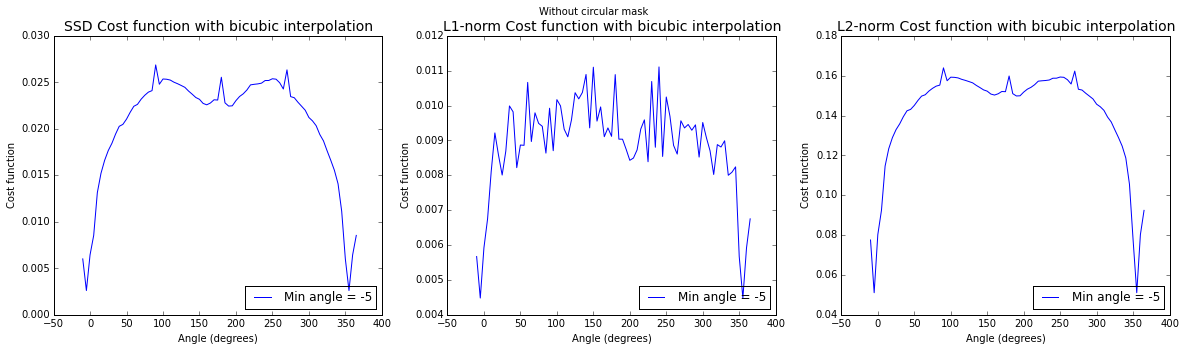

In [33]:
# Cost function from Bicubic Interpolation with wide range
thetas=np.arange(-10,370,5)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bicubic')
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bicubic')
plt.show()
plt.close(fig)

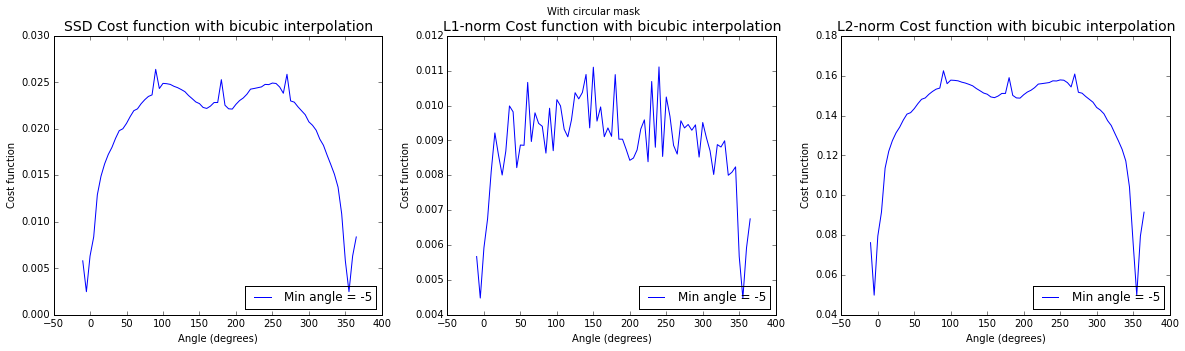

In [34]:
# Cost function from Bicubic Interpolation with wide range
# with circular mask
thetas=np.arange(-10,370,5)
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("With circular mask")
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bicubic', mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bicubic', mask=True)
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bicubic', mask=True)
plt.show()
plt.close(fig)

## Use Halton Sampling to Evaluate Cost Function ##

In [37]:
def Halton_cost_func(N, vol1, vol2, thetas, cf, arg, interpolation = 'bicubic',mask=False):
    '''
    N: Number of points for Halton Sampling
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    t0 = time.time()
    # generate Halton Sequence in the 32*32*32 grid
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    
    new_vol1 = np.empty([vol1.shape[0],N,N])
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.empty([vol2.shape[0],N,N])
        for i in xrange(32):
            if(mask):
                vol1[i,:,:] = circle_mask(vol1[i,:,:])
            sub = vol2[i,:,:]
            rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = bicubic_interp(rot, x1, y1)
            sub1 = vol1[i,:,:]
            new_vol1[i,:,:] = bicubic_interp(sub1, x1, y1)
        cost_func[idx] = cf(new_vol2,new_vol1)
    t1 = time.time()
    print 'Time for %s halton samples is %s seconds' % (N,t1-t0)
    
    angMin = thetas[np.argmin(cost_func)]
    plt.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    plt.title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Cost function')
    plt.legend(loc=4)

Time for 100 halton samples is 14.6115050316 seconds


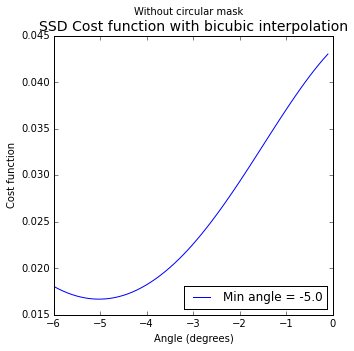

In [38]:
# Cost Function from Bicubic Interpolation with Halton Sampling
N = 100
thetas=np.arange(-6,0,0.1)
# without circular mask
fig, ax = plt.subplots(1,1)
fig.set_figwidth(5)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
Halton_cost_func(N, vol1, vol2, thetas, cf_ssd, 'SSD', interpolation='bicubic')
plt.show()
plt.close(fig)

In [ ]:
# Cost Function from Bicubic Interpolation with Halton Sampling
N = 1000
thetas=np.arange(-6,0,0.1)
# without circular mask
fig, ax = plt.subplots(1,1)
fig.set_figwidth(5)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
Halton_cost_func(N, vol1, vol2, thetas, cf_ssd, 'SSD', interpolation='bicubic')
plt.show()
plt.close(fig)